# <center> Movie Review Sentiment Analysis </center>
## <center> Classify the sentiment of sentences from the Rotten Tomatoes dataset </center>

Deep learning - Feb. 2020  
Thomas de Mareuil - Tommy Tran  
Ecole Polytechnique

##  Contents

In this notebook we will go through the following steps:
-  Introduction of the dataset
-  Data exploration and visualization
-  Deep Learning models:  preprocessing, LSTM, GRU, Bi-directionnal
-  Baseline machine learning models
      
---
* [Introduction](#introduction)
* [Exploratory Data Analysis](#eda)
---
* [Deep learning models: RNN](#DL)
  *  [Preprocessing](#lstm)
  *  [LSTM model](#lstm)
  *  [GRU model](#gru)
  *  [Bidirectional-GRU model](#bgru)
  *  [CNN model](#cnn)
---
* [Machine Learning Models without RNN (baselines)](#ml)
  *  [N-Grams Method](#N-Grams)
---

<a id='introduction'></a>
## <center> Introduction </center>

From https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview/description


The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.




![treebank.png](treebank.png)



More on the sentiment treebank https://nlp.stanford.edu/sentiment/treebank.html

In [19]:
# imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(42)

Our first job will be to explore and pre-process our text data so we can use it for modeling. Pre-processing will be more complex than for, e.g., images, which can naturally be transformed into arrays (of size number of pixels * 3) with numerical values (in [0;255] for example).

<a id='eda'></a>
## <center>Exploratory Data Analysis </center>

Let's start with basic exploration of the data to check labels, the number of phrases for each label (i.e. each sentiment), etc.

### Train dataset

In [20]:
train = pd.read_csv('train.tsv', sep = '\t')
test  = pd.read_csv('test.tsv', sep = '\t')

In [61]:
train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [62]:
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2



We can already make a few remarks:
- each sentence (i.e. each review, identified by `SentenceId`) is split into several phrases (i.e. segments, identified by `PhraseId`)
- all portions are labelled (by hand, by Mechanical Turk), starting at 0 = negative

In [63]:
# number of phrases corresponding to the 1st sentence

len(train.Phrase[train.SentenceId == 1])

63

In [64]:
# first full sentence

train.Phrase[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

The sentiment in this 1st sentence isn't quite obvious... The label here is `1`, i.e. 'somewhat negative'.

In [65]:
# number of sentences (reviews) and phrases in the dataset

print('There are %d sentences in the train dataset' % len(np.unique(train.SentenceId)))
print('The max SentenceId is', max(train.SentenceId))

print('There are %d phrases in the train dataset' % train.PhraseId.nunique())

print('Average phrases per sentence in train dataset:',train.groupby('SentenceId')['Phrase'].count().mean())

There are 8529 sentences in the train dataset
The max SentenceId is 8544
There are 156060 phrases in the train dataset
Average phrases per sentence in train dataset: 18.297572986282095


We can remark that the commands `nunique` and `len(np.unique)` are more precise than `max()`, as the Ids can skip numbers (this is the case with `SentenceId`, max is 8544 while there are only 8529 unique sentences).

### Test dataset

In [66]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


As the data is from a Kaggle competition, the test dataset doesn't have labels. We could submit on kaggle to get our score.

Therefore **to evaluate our model locally we need to create a validation dataset**. For that, we will split our train set with the `train_test_split command`, so that we obtain a train set and a validation/local test set.

**Important remarks**:
- our rows are **not** independent (phrases from the same sentence intersect with each other) 
- we need to put independant data points, i.e. **different sentences** (sentences are independent from each other, but phrases are not) in the train and validation sets, so that there is no intersection between our train and test datasets

### Sentiment labels

The 5 labels are:  
0 - negative  
1 - somewhat negative  
2 - neutral  
3 - somewhat positive  
4 - positive

In [67]:
# Number of phrases for each sentiment

class_count = train['Sentiment'].value_counts()
class_count

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

Text(0, 0.5, 'Number of reviews ')

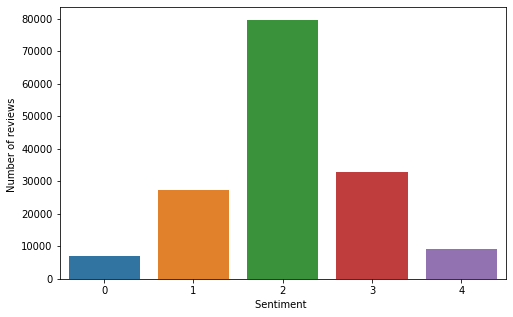

In [68]:
x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8, 5))
sns.barplot(x, y)
plt.xlabel('Sentiment ')
plt.ylabel('Number of reviews ')

### Word Clouds to see the most frequents words for each sentiment

For this section we used the `wordcloud` package, described in this [GitHub](https://github.com/amueller/word_cloud) and in this [blog page](https://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html).

In [69]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

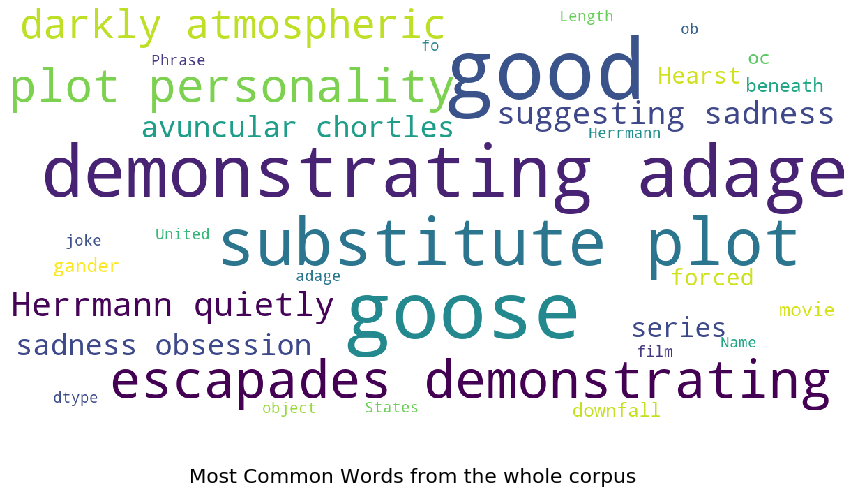

In [70]:
show_wordcloud(train['Phrase'], 'Most Common Words from the whole corpus')

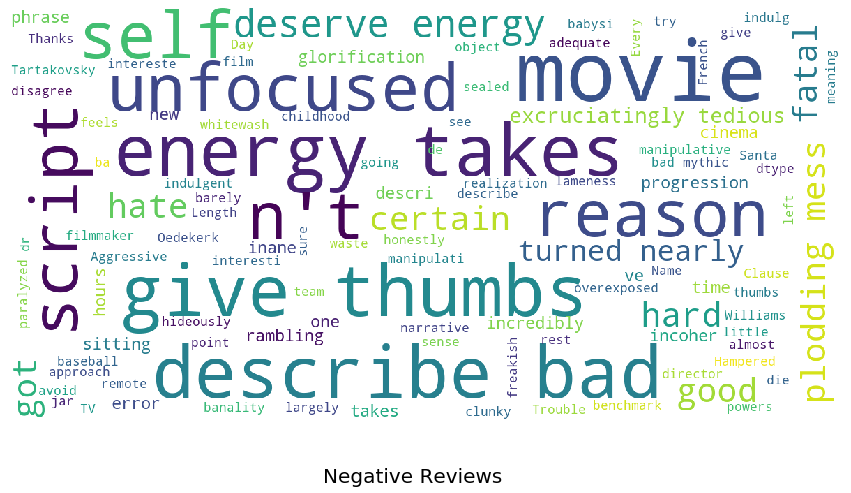

In [71]:
show_wordcloud(train[train.Sentiment == 0]['Phrase'],'Negative Reviews')

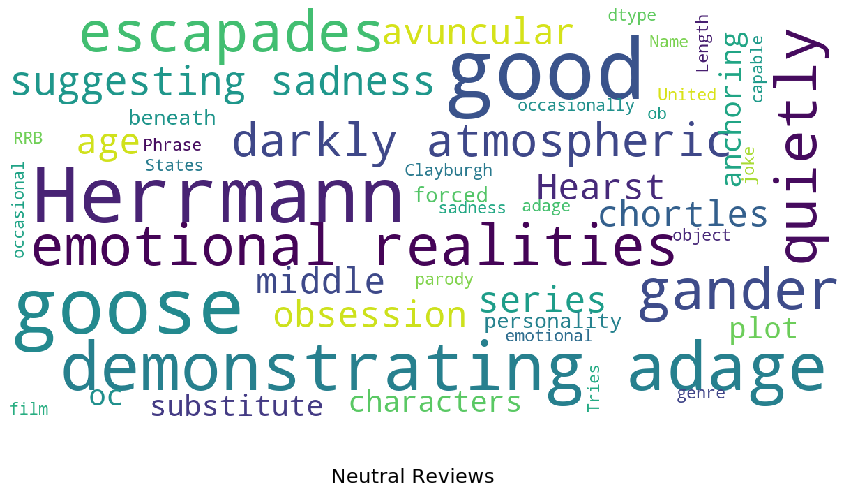

In [72]:
show_wordcloud(train[train['Sentiment'] == 2]['Phrase'],'Neutral Reviews')

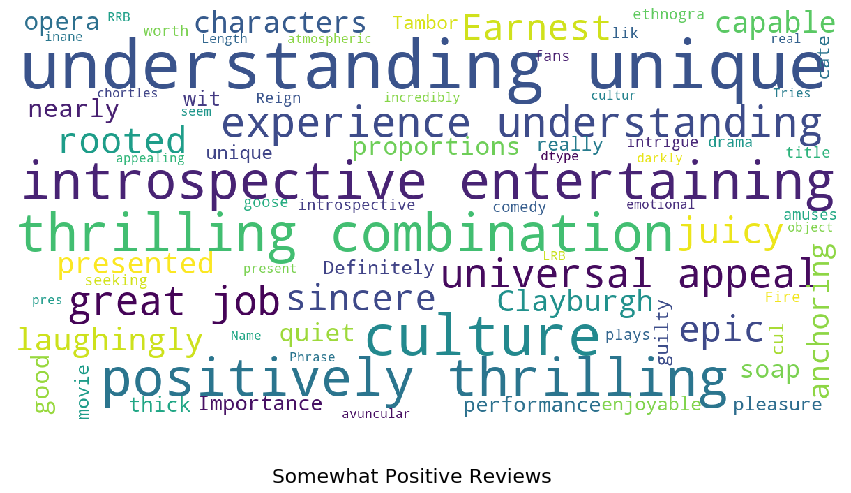

In [73]:
show_wordcloud(train[train['Sentiment'] == 3]['Phrase'],'Somewhat Positive Reviews')

---
<a id='DL'></a>
# <center> Deep Learning models: RNN</center>

In this section we will implement several Recurrent Neural Networks with Keras to predict labels:
- based on LSTM
- based on GRU
- based on Bi-directional GRU
- based on CNN

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

Using TensorFlow backend.


## <center> 1. Preprocessing </center>

We went through the following steps:
- Perform the train-test split
- Transform the labels into categories
- Transform lists of sentences into useable arrays:
  - Each word is mapped to a number
  - Lists of numbers are padded with 0 or truncated to fit in an array.

###  Perform the train-validation split

We will split our train dataset to obtain:
- X_train
- X_val
- Y_train
- Y_val

As remarked above, we need to make sure we separate sentences:

In [22]:
from sklearn.model_selection import train_test_split

Sent_train, Sent_val = train_test_split(train.SentenceId.unique(), test_size=0.20)
Sent_train, Sent_val

(array([2906, 7210, 1466, ..., 3524, 3217, 7523]),
 array([2777, 5107, 6194, ..., 3765, 3749, 3229]))

In [76]:
# the line below shows the first phrases corresponding to the Sent_val split
train[train.SentenceId.isin(Sent_val)].head()

,PhraseId,SentenceId,Phrase,Sentiment
156,157,5,Aggressive self-glorification and a manipulati...,1
157,158,5,Aggressive self-glorification and a manipulati...,0
158,159,5,Aggressive,2
159,160,5,self-glorification and a manipulative whitewash,0
160,161,5,self-glorification and,1


**Remark**: in the cell below, to build each dataset we select in `train` only the **phrases** which correspont to the SentenceIds defined in our split - as we do not need the Id columns any more for our model (we just need the phrases in `X_train` and the labels in `Y_train`, and same in `X_val` and `Y_val`).

In [39]:
X_train = train.Phrase.values[train.SentenceId.isin(Sent_train)]
X_val = train.Phrase.values[train.SentenceId.isin(Sent_val)]
Y_train = train.Sentiment.values[train.SentenceId.isin(Sent_train)]
Y_val = train.Sentiment.values[train.SentenceId.isin(Sent_val)]

The `train_test_split` already shuffles data, but with the `isin` command we re-ordered phrases when selecting them to build our sets.
Remark: we do not shuffle the `X_train` and `Y_train` sets separately, so as not to loose coorespondence:

In [41]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train)

In [79]:
X_train[:5] # 5 first phrases in X_train

array(["you 're going to subjugate truth to the tear-jerking demands of soap opera",
       'in an unexpected direction', 'Made to be Jaglomized is',
       'dangers', 'the happily-ever'], dtype=object)

In [80]:
X_val[-5:] # 5 last phrases in X_val

array(['believed', 'in their small-budget film',
       'their small-budget film', 'small-budget film', 'small-budget'],
      dtype=object)

In [81]:
Y_val

array([1, 0, 2, ..., 2, 2, 1])

### Transform the target into a categorical variable

In [40]:
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

Y_train[-5:] # view last five rows

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

### Transform the lists of sentences into an array

In the following cells, we now tokenize the train and test set:

In [26]:
max_features = 13000 # total number of different words
max_words = 50 # max length of representation
num_classes = 5 # number of different classes / sentiments

In [84]:
Phrase0 = X_train[0]

In [42]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val   = tokenizer.texts_to_sequences(X_val)
type(X_train)

list

The tokenizer maps each phrase into a sequence of numbers (1 per word), based on a word dictionary (visible below with the `word_index` command). It also removes punctuation and capital letters.

In [86]:
print(Phrase0)
print(X_train[0])

you 're going to subjugate truth to the tear-jerking demands of soap opera
[22, 139, 221, 5, 6268, 658, 5, 1, 869, 2874, 1666, 3, 446, 343]


In [87]:
# show the first 10 words and corresponding numbers in the tokenizer word_index

dict(list(tokenizer.word_index.items())[:10]) # 'items()' functions only on a list

{'the': 1,
 'a': 2,
 'of': 3,
 'and': 4,
 'to': 5,
 "'s": 6,
 'in': 7,
 'is': 8,
 'that': 9,
 'it': 10}

**Remark**: the words are sorted by number of occurences. We can see the number of occurences of each word as follows:

In [88]:
# show the number of occurences of the 10 most frequent words

dict(sorted(tokenizer.word_counts.items(),
            key=lambda x:x[1],
            reverse=True)[:10]) # we reverse-sort the dictionary on values

{'the': 41717,
 'a': 29231,
 'of': 26424,
 'and': 26042,
 'to': 18634,
 "'s": 13582,
 'in': 11333,
 'is': 10930,
 'that': 9931,
 'it': 9533}

Finally, we **pad sequences** in order to limit the length of any sequence to a maximal length of 50 (we choose max_words=50 for computational simplicity - 50 words is larger than the huge majority of sentences). We pad with zeros for sentences shorter than 50 words.

In [43]:
X_train = pad_sequences(X_train, maxlen=max_words)
X_val = pad_sequences(X_val, maxlen=max_words)

In [90]:
X_train.shape

(125010, 50)

$\rightarrow$ All 124971 phrases in our train set are now transformed in arrays of length 50 with left 0-padding.

The first sentence is represented as follows:

In [91]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,   22,  139,  221,    5, 6268,  658,    5,    1,
        869, 2874, 1666,    3,  446,  343], dtype=int32)

<a id='lstm'></a>
## <center>2. LSTM</center>


Our first neural network uses LSTM. It includes:

- an Embedding layer (turns positive integers (indexes) into dense vectors of fixed size)
  - we embed words in dimension 100 (arbitrary choice)
  - we need embedding to give 'meaning' to the geometry of our words' representation

- a 1st LSTM layer:
  - with 64 units
  - dropout of 0.5 

- a 2nd LSTM layer:
  - with 32 units
  - dropout of 0.5

- a final dense Layer :
  - with output size = num_classes
  - softmax activation

In [28]:
import warnings
warnings.filterwarnings("ignore") #to ignore unnecessary warnings raised by this cell

model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 100, mask_zero=True))
model_LSTM.add(LSTM(64, dropout=0.5, return_sequences=True))  
model_LSTM.add(LSTM(32, dropout=0.5, return_sequences=False)) 
model_LSTM.add(Dense(num_classes, activation='softmax'))     

When compiling the model, we chose the binary crossentropy as our loss function (since it is a multi-class classification problem), the Adam optimizer with learning rate 0.001 and accuracy for the metrics.

In [95]:
model_LSTM.compile(loss='binary_crossentropy',
                    optimizer=Adam(lr=0.001),
                    metrics=['accuracy'])

In [96]:
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1300000   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 1,354,821
Trainable params: 1,354,821
Non-trainable params: 0
_________________________________________________________________


**Comment on the number of parameters:**
- Embedding layer: nb of params = max_features x dim Embedding. Here, $13000 x 100 = 1 300 000$
- 1st LSTM layer: nb of params = 4 x (size_of_input + 1) x (size_of_output) + (size_of_output)^2. Here, $4*64*(100+1+64) = 42240$
- Dense layer: nb of params = (output dimension of previous layer + 1) x (output) (the +1 is for the biases). Here, $(32+1)*5=165$

We now **fit the model** using 1 epoch only (very long to do more on a MacBook Air) and `batch_size = 128`.

For better accuracy in a Kaggle competition, we would fit on more epochs and plot accuracy on validation set vs. number of epochs, in order to determine the moment when it starts to **overfit** (i.e. the moment when training accuracy continues improving but validation accuracy starts stagnating or declining), and we would stop training at this nb of epochs.

In [34]:
batch_size = 128
epochs = 1

In [112]:
%%time
history_LSTM = model_LSTM.fit(X_train, Y_train,
                              validation_data=(X_val, Y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=1)

Train on 124971 samples, validate on 31089 samples
Epoch 1/1
124971/124971 [==============================] - 814s 7ms/step - loss: 0.3564 - acc: 0.8434 - val_loss: 0.3431 - val_acc: 0.8456
CPU times: user 35min 45s, sys: 2min 32s, total: 38min 18s
Wall time: 13min 37s


When testing different hyperparameters, we also observed that:
- training time depends on the length of the input sequence (max_words)
- reducing the dimension of the embedding does not really change the training time

<a id='gru'></a>
## <center>3. GRU</center>

We tried a network with the exact same architecture but using a GRU unit instead of the LSTM unit.

In [30]:
model_GRU=Sequential()
model_GRU.add(Embedding(max_features,100,mask_zero=True))
model_GRU.add(GRU(64,dropout=0.5,return_sequences=True))
model_GRU.add(GRU(32,dropout=0.5,return_sequences=False))
model_GRU.add(Dense(num_classes,activation='softmax'))
model_GRU.compile(loss='binary_crossentropy',optimizer=Adam(lr = 0.001),metrics=['acc'])
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1300000   
_________________________________________________________________
gru_3 (GRU)                  (None, None, 64)          31680     
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 1,341,157
Trainable params: 1,341,157
Non-trainable params: 0
_________________________________________________________________


In [116]:
%%time
history_GRU = model_GRU.fit(X_train, Y_train,
                            validation_data=(X_val, Y_val),
                            epochs=epochs,
                            batch_size=batch_size, 
                            verbose=1)

Train on 124971 samples, validate on 31089 samples
Epoch 1/1
124971/124971 [==============================] - 657s 5ms/step - loss: 0.3481 - acc: 0.8457 - val_loss: 0.3421 - val_acc: 0.8455
CPU times: user 27min 34s, sys: 2min, total: 29min 34s
Wall time: 11min 2s


The validation accuracy after 1 epoch is sensibly the same as with LSTM, with training time a little shorter.

<a id='bgru'></a>
## <center>4. Bidirectional GRU</center>

Similarly, we tried a model with the same architecture but the Bidirectional GRU unit.

In [31]:
model_BGRU = Sequential()
model_BGRU.add(Embedding(max_features, 100, input_length=max_words))
model_BGRU.add(SpatialDropout1D(0.25))
model_BGRU.add(Bidirectional(GRU(64,dropout=0.4,return_sequences = True)))
model_BGRU.add(Bidirectional(GRU(32,dropout=0.5,return_sequences = False)))
model_BGRU.add(Dense(5, activation='sigmoid'))
model_BGRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_BGRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1300000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           63360     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                30912     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 1,394,597
Trainable params: 1,394,597
Non-trainable params: 0
_________________________________________________________________


In [44]:
%%time
history_BGRU = model_BGRU.fit(X_train, Y_train, 
                               validation_data=(X_val, Y_val),
                               epochs=epochs, 
                               batch_size=batch_size, 
                               verbose=1)

Train on 125132 samples, validate on 30928 samples
Epoch 1/1
125132/125132 [==============================] - 941s 8ms/step - loss: 0.3485 - acc: 0.8469 - val_loss: 0.3340 - val_acc: 0.8517
CPU times: user 50min 38s, sys: 2min 57s, total: 53min 36s
Wall time: 15min 44s


Validation accuracy is a little higher than with LSTM, but training time is significantly longer.

<a id='cnn'></a>
## <center>5.CNN</center>

Finally, we also tried a CNN model:

In [32]:
model_CNN= Sequential()
model_CNN.add(Embedding(max_features,100,input_length=max_words))
model_CNN.add(Dropout(0.2))
model_CNN.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(128,activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(num_classes,activation='sigmoid'))
model_CNN.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1300000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            19264     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total para

In [45]:
%%time
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

history_CNN = model_CNN.fit(X_train, Y_train, 
                            validation_data=(X_val, Y_val),
                            epochs=epochs,
                            batch_size=batch_size, 
                            verbose=1,
                            callbacks = [early_stop])

Train on 125132 samples, validate on 30928 samples
Epoch 1/1
125132/125132 [==============================] - 198s 2ms/step - loss: 0.3461 - acc: 0.8458 - val_loss: 0.3296 - val_acc: 0.8521
CPU times: user 9min 14s, sys: 7.59 s, total: 9min 21s
Wall time: 3min 20s


Validation accuracy is a little higher than with LSTM and training time is quite shorter - but this is only after one epoch; to better compare to LSTM we would need to train both models on more epochs.

<a id='ml'></a>
# <center> Baseline models (without RNN) </center>


We used the Natural Language Toolkit NLTK package, https://www.nltk.org/.

In [3]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
tokenizer = TweetTokenizer()
np.set_printoptions(precision=2)

<a id=' N-Grams'></a>
###  N-Grams

We first vectorize the training (and testing) data:
- we first make a list of all phrases, in the variable `full_text`
- we tokenize the full text, using n-grams (only  uni-grams an bi-grams) and Tfidf metric

In [4]:
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)

A simple `CountVectorizer` would transform phrases into sparse arrays of length = total number of words from all phrases, with each word transformed into a number corresponding to its frequency (word count) in the phrase. `X_count` is a sparse matrix corresponding to the vectorization of all phrases. The word order (syntax) **is not preserved** (vs. LSTM that does take order into account).

$\rightarrow$ Instead of a simple word count, we use the **tfidf** transform, which computes a **relative importance of words** (see details [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
vectorizer.fit(full_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1a21b8bef0>>,
                use_idf=True, vocabulary=None)

In [6]:
train_vectorized = vectorizer.transform(train['Phrase'])
test_vectorized = vectorizer.transform(test['Phrase'])

In [7]:
# see the last 10 features (n-grams)
print(list(vectorizer.get_feature_names())[-10:])

['zoom !', 'zucker', 'zucker brothers', 'zucker brothers \\', 'zwick', 'zwick ,', 'zwick , is', 'zwick , it', 'zzzzzzzzz', 'zzzzzzzzz .']


In [8]:
# most frequent word
vectorizer.get_feature_names()[np.argmax(np.sum(train_vectorized,0))]

'the'

In [109]:
# shape of the sparse matrix & number of n-grams in the dataset
train_vectorized

<156060x301627 sparse matrix of type '<class 'numpy.float64'>'
	with 2963106 stored elements in Compressed Sparse Row format>

In [108]:
# print the sparse matrix with relative importance of words
print(train_vectorized.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
# train-test split
y = train['Sentiment']
x_train, x_val, y_train, y_val = train_test_split(train_vectorized, y, test_size = 0.2)

We will now train a Logistic Regression model (one vs. rest classifier), an SVM, and a voting classifier ensembling both of them (hard voting):

### Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [16]:
lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train, y_train)
print(classification_report(ovr.predict(x_val), y_val))
print(accuracy_score(ovr.predict(x_val), y_val))

/Users/Thomas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.16      0.65      0.25       360
           1       0.33      0.55      0.41      3237
           2       0.90      0.65      0.76     22285
           3       0.42      0.58      0.49      4726
           4       0.22      0.69      0.34       604

    accuracy                           0.63     31212
   macro avg       0.41      0.62      0.45     31212
weighted avg       0.75      0.63      0.67     31212

0.6292451621171344


### SVM

In [17]:
svm = LinearSVC()
svm.fit(x_train, y_train)
print(classification_report(svm.predict(x_val), y_val))
print(accuracy_score(svm.predict(x_val), y_val))

              precision    recall  f1-score   support

           0       0.37      0.50      0.42      1087
           1       0.50      0.55      0.52      4908
           2       0.81      0.73      0.77     17838
           3       0.52      0.58      0.55      5919
           4       0.43      0.55      0.48      1460

    accuracy                           0.65     31212
   macro avg       0.53      0.58      0.55     31212
weighted avg       0.68      0.65      0.66     31212

0.6549083685761886


### Ensembling (voting classifier)

In [18]:
estimators = [('svm', svm), ('ovr', ovr)]
clf = VotingClassifier(estimators , voting='hard')
clf.fit(x_train,y_train)
print(classification_report( clf.predict(x_val), y_val))
print(accuracy_score(clf.predict(x_val), y_val))

/Users/Thomas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.37      0.50      0.42      1098
           1       0.51      0.54      0.52      5081
           2       0.86      0.69      0.76     19961
           3       0.42      0.60      0.49      4499
           4       0.21      0.70      0.33       573

    accuracy                           0.64     31212
   macro avg       0.47      0.60      0.51     31212
weighted avg       0.71      0.64      0.66     31212

0.643758810713828


$\rightarrow$ The most accurate method without neural networks is the SVM.